In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=c89ebc8649abbbe42fb917541b7b4d406d4df34df3fe7f0f6942fe1a91ab05b2
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=609eae19284158d8da5e0e9c3038194eff890746b2f733ef1aaaeb7e8ccb0e3f
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

In [ ]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp310-cp310-linux_x86_64.whl size=3541558 sha256=3eaba76ee56c5731b1d077711db9c88152902e23d5021932c41b818129ed0d04
  Stored in directory: /root/.cache/pip/wheels/dc/52/e3/6c6b60b126b4d5c4370cb5ac071b82950f91649d62d72f7f56
Successfully built hdbscan


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import hdbscan

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

# Flowers Dataset and VGG Features

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content) # df.to_csv("file name")
        """
        import pickle
        with open('./flower_photos.tgz', 'wb') as f:
          pickle.dump(obj, f)
        
        with open('./flower_photos.tgz', 'rb') as f:
          obj = pickle.load(f)

        a = 1
        b = 2
        c = Object
        
        combined_list = [a, b, c]
        """
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available() # check the google colab GPU settings
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                      transform=transforms.Compose([transforms.Resize(224),
                      transforms.CenterCrop(224),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s]
100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]
print(num_features)

(3670, 4096) (3670,)
4096


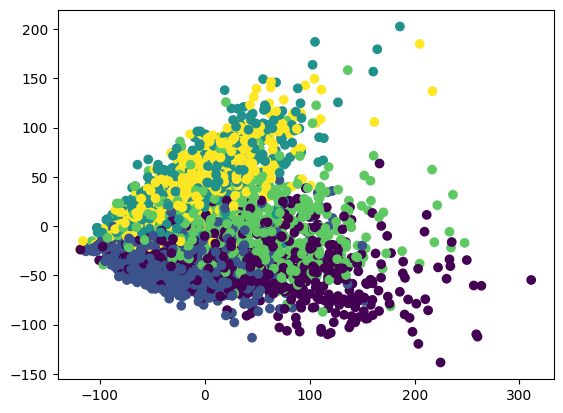

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

## T-SNE

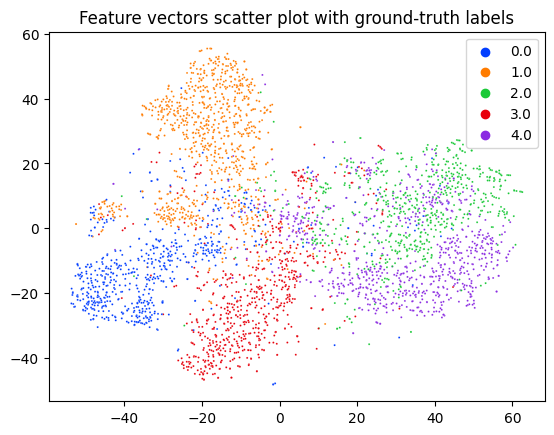

In [ ]:
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
tsne_result = tsne.fit_transform(f_all)

color_set = sns.color_palette("bright", 5)
sns.scatterplot(data=tsne_result,x=tsne_result[:,0], y=tsne_result[:,1], 
            hue=y_all, legend='full', palette=color_set, s=2)

plt.title("Feature vectors scatter plot with ground-truth labels")
plt.show()


# Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

### Dimensionality Reduction


In [ ]:
#Dimensionality Reduction Setup
# SVD
DR_SVD = TruncatedSVD(n_components=50)
DR_SVD_data = DR_SVD.fit_transform(f_all)
# UMAP
DR_UMAP = umap.UMAP(n_components=50, metric='cosine')
DR_UMAP_data = DR_UMAP.fit_transform(f_all)
# Autoencoder
DR_Autoencoder = Autoencoder(50)
DR_Autoencoder_data = DR_Autoencoder.fit_transform(f_all)

100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


### K-Mean

In [ ]:
km_model = KMeans(n_clusters=5, n_init=30, max_iter=1000, random_state=42)

#Without dimensinality reduction
km_NDR_pred = km_model.fit_predict(f_all)
km_NDR_result = metrics.adjusted_rand_score(y_all, km_NDR_pred)
print(f"The rand score of K-means without Dimensionality Reduction: {km_NDR_result}.")

#With Dimensionality Reduction SVD
km_SVD_pred = km_model.fit_predict(DR_SVD_data)
km_SVD_result = metrics.adjusted_rand_score(y_all, km_SVD_pred)
print(f"The rand score of K-means with Dimensionality Reduction SVD: {km_SVD_result}.")

#With Dimensionality Reduction UMAP
km_UMAP_pred = km_model.fit_predict(DR_UMAP_data)
km_UMAP_result = metrics.adjusted_rand_score(y_all, km_UMAP_pred)
print(f"The rand score of K-means with Dimensionality Reduction UMAP: {km_UMAP_result}.")

#With Dimensionality Reduction Autoencoder
km_Autoencoder_pred = km_model.fit_predict(DR_Autoencoder_data)
km_Autoencoder_result = metrics.adjusted_rand_score(y_all, km_Autoencoder_pred)
print(f"The rand score of K-means with Dimensionality Reduction Autoencoder: {km_Autoencoder_result}.")

The rand score of K-means without Dimensionality Reduction: 0.1967464897299102.
The rand score of K-means with Dimensionality Reduction SVD: 0.19471455690070258.
The rand score of K-means with Dimensionality Reduction UMAP: 0.46712623723341.
The rand score of K-means with Dimensionality Reduction Autoencoder: 0.2887958286594561.


### Agglomerative Clustering

In [ ]:
agg_model = AgglomerativeClustering(n_clusters=5)

#Without dimensinality reduction
agg_NDR_pred = agg_model.fit_predict(f_all)
agg_NDR_result = metrics.adjusted_rand_score(y_all, agg_NDR_pred)
print(f"The rand score of Agglomerative Clustering without Dimensionality Reduction: {agg_NDR_result}.")

#With Dimensionality Reduction SVD
agg_SVD_pred = agg_model.fit_predict(DR_SVD_data)
agg_SVD_result = metrics.adjusted_rand_score(y_all, agg_SVD_pred)
print(f"The rand score of Agglomerative Clustering with Dimensionality Reduction SVD: {agg_SVD_result}.")

#With Dimensionality Reduction UMAP
agg_UMAP_pred = agg_model.fit_predict(DR_UMAP_data)
agg_UMAP_result = metrics.adjusted_rand_score(y_all, agg_UMAP_pred)
print(f"The rand score of Agglomerative Clustering with Dimensionality Reduction UMAP: {agg_UMAP_result}.")

#With Dimensionality Reduction Autoencoder
agg_Autoencoder_pred = agg_model.fit_predict(DR_Autoencoder_data)
agg_Autoencoder_result = metrics.adjusted_rand_score(y_all, agg_Autoencoder_pred)
print(f"The rand score of Agglomerative Clustering with Dimensionality Reduction Autoencoder: {agg_Autoencoder_result}.")

The rand score of Agglomerative Clustering without Dimensionality Reduction: 0.18855278251971858.
The rand score of Agglomerative Clustering with Dimensionality Reduction SVD: 0.19484385901282925.
The rand score of Agglomerative Clustering with Dimensionality Reduction UMAP: 0.4602857886665337.
The rand score of Agglomerative Clustering with Dimensionality Reduction Autoencoder: 0.3112159145501919.


### HDBSCAN

In [ ]:
mcs_list = [5,10,20]
ms_list = [1,2,3]

#Without dimensinality reduction
for i in mcs_list:
  for j in ms_list:
    hdbs_model = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j )
    hdbs_pred = hdbs_model.fit_predict(f_all)
    hdbs_result = metrics.adjusted_rand_score(y_all, hdbs_pred)
    print(f"HDBSCAN without Dimensionality Reduction: \n the min cluster size is {i}, the min samples is {j}, the rand score is {hdbs_result}")

HDBSCAN without Dimensionality Reduction: 
 the min cluster size is 5, the min samples is 1, the rand score is 0.014983034591038287
HDBSCAN without Dimensionality Reduction: 
 the min cluster size is 5, the min samples is 2, the rand score is 0.029935533978548482
HDBSCAN without Dimensionality Reduction: 
 the min cluster size is 5, the min samples is 3, the rand score is 0.0036771581900148067
HDBSCAN without Dimensionality Reduction: 
 the min cluster size is 10, the min samples is 1, the rand score is 0.015014212771105666
HDBSCAN without Dimensionality Reduction: 
 the min cluster size is 10, the min samples is 2, the rand score is 0.008005957976325214
HDBSCAN without Dimensionality Reduction: 
 the min cluster size is 10, the min samples is 3, the rand score is 0.005992335809378017
HDBSCAN without Dimensionality Reduction: 
 the min cluster size is 20, the min samples is 1, the rand score is 0.0
HDBSCAN without Dimensionality Reduction: 
 the min cluster size is 20, the min samples 

In [ ]:
#With Dimensionality Reduction SVD
for i in mcs_list:
  for j in ms_list:
    hdbs_model = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j )
    hdbs_pred = hdbs_model.fit_predict(DR_SVD_data)
    hdbs_result = metrics.adjusted_rand_score(y_all, hdbs_pred)
    print(f"HDBSCAN with Dimensionality Reduction SVD: \n the min cluster size is {i}, the min samples is {j}, the rand score is {hdbs_result}")

HDBSCAN with Dimensionality Reduction SVD: 
 the min cluster size is 5, the min samples is 1, the rand score is 0.023013052406648866
HDBSCAN with Dimensionality Reduction SVD: 
 the min cluster size is 5, the min samples is 2, the rand score is 0.0236783116118293
HDBSCAN with Dimensionality Reduction SVD: 
 the min cluster size is 5, the min samples is 3, the rand score is 0.025919670472321747
HDBSCAN with Dimensionality Reduction SVD: 
 the min cluster size is 10, the min samples is 1, the rand score is 0.016953961831338113
HDBSCAN with Dimensionality Reduction SVD: 
 the min cluster size is 10, the min samples is 2, the rand score is 0.010610670426786473
HDBSCAN with Dimensionality Reduction SVD: 
 the min cluster size is 10, the min samples is 3, the rand score is 0.015383828262902601
HDBSCAN with Dimensionality Reduction SVD: 
 the min cluster size is 20, the min samples is 1, the rand score is 0.026838053573625488
HDBSCAN with Dimensionality Reduction SVD: 
 the min cluster size i

In [ ]:
#With Dimensionality Reduction UMAP
for i in mcs_list:
  for j in ms_list:
    hdbs_model = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j )
    hdbs_pred = hdbs_model.fit_predict(DR_UMAP_data)
    hdbs_result = metrics.adjusted_rand_score(y_all, hdbs_pred)
    print(f"HDBSCAN with Dimensionality Reduction UMAP: \n the min cluster size is {i}, the min samples is {j}, the rand score is {hdbs_result}")

HDBSCAN with Dimensionality Reduction UMAP: 
 the min cluster size is 5, the min samples is 1, the rand score is 0.20044958343755134
HDBSCAN with Dimensionality Reduction UMAP: 
 the min cluster size is 5, the min samples is 2, the rand score is 0.09494009559863244
HDBSCAN with Dimensionality Reduction UMAP: 
 the min cluster size is 5, the min samples is 3, the rand score is 0.09494009559863244
HDBSCAN with Dimensionality Reduction UMAP: 
 the min cluster size is 10, the min samples is 1, the rand score is 0.09494009559863244
HDBSCAN with Dimensionality Reduction UMAP: 
 the min cluster size is 10, the min samples is 2, the rand score is 0.09494009559863244
HDBSCAN with Dimensionality Reduction UMAP: 
 the min cluster size is 10, the min samples is 3, the rand score is 0.09494009559863244
HDBSCAN with Dimensionality Reduction UMAP: 
 the min cluster size is 20, the min samples is 1, the rand score is 0.09494009559863244
HDBSCAN with Dimensionality Reduction UMAP: 
 the min cluster siz

In [ ]:
#With Dimensionality Reduction Autoencoder
for i in mcs_list:
  for j in ms_list:
    hdbs_model = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j )
    hdbs_pred = hdbs_model.fit_predict(DR_Autoencoder_data)
    hdbs_result = metrics.adjusted_rand_score(y_all, hdbs_pred)
    print(f"HDBSCAN with Dimensionality Reduction Autoencoder: \n the min cluster size is {i}, the min samples is {j}, the rand score is {hdbs_result}")

HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 5, the min samples is 1, the rand score is 0.0071688287978370025
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 5, the min samples is 2, the rand score is 0.01901010675794912
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 5, the min samples is 3, the rand score is 0.016837286767782293
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 10, the min samples is 1, the rand score is 0.029240206141425674
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 10, the min samples is 2, the rand score is 0.02930891418905757
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 10, the min samples is 3, the rand score is 0.024622023097276093
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 20, the min samples is 1, the rand score is 0.004632991345650211
HDBSCAN wi

# MLP Classifier

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # implement part        #
                ##################################
                #raise NotImplementedError

                #reset the gradients
                optimizer.zero_grad()
                #forward pass
                outputs = self.model(X_)
                loss = criterion(outputs, y_)

                #forward pass
                loss.backward()

                #optimizer
                optimizer.step()

        return self
    
    def eval(self, X_test, y_test):
        ##################################
        #implement part #
        ##################################
        #raise NotImplementedError
        self.model.eval()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        correct_number = 0
        outputs = self.model(X_test)
        _, predict_result = torch.max(outputs, 1)
        total_number = len(y_test)
        correct_number += torch.sum(predict_result == y_test)
  
        accuracy = "{:.2%}".format(correct_number/total_number)
        return accuracy   

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    f_all,
    y_all,  
    test_size=0.2, 
    random_state=42)

In [ ]:
# MLP classifier without Dimensionality Reduction on VGG
MLP_NDR = MLP(num_features = f_all.shape[1])
MLP_NDR.train(X_train,y_train)
ACC_NDR = MLP_NDR.eval(X_test,y_test)
print(f"The accuracy of MLP classifier without Dimensionality Reduction on VGG: {ACC_NDR}.")

100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


The accuracy of MLP classifier without Dimensionality Reduction on VGG: 90.87%.


In [ ]:
# MLP classifier with Dimensionality Reduction on SVD
DR_SVD = TruncatedSVD(n_components=50)

X_train_SVD = DR_SVD.fit_transform(X_train)
X_test_SVD = DR_SVD.fit_transform(X_test)

MLP_SVD = MLP(num_features=50)
MLP_SVD.train(X_train_SVD,y_train)
ACC_SVD = MLP_SVD.eval(X_test_SVD,y_test)

print(f"\n The accuracy of MLP classifier with Dimensionality Reduction SVD on VGG: {ACC_SVD}.")

100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


 The accuracy of MLP classifier with Dimensionality Reduction SVD on VGG: 4.77%.


In [ ]:
# MLP classifier with Dimensionality Reduction on SVD
DR_UMAP = umap.UMAP(n_components=50, metric='cosine')

X_train_UMAP = DR_UMAP.fit_transform(X_train)
X_test_UMAP = DR_UMAP.fit_transform(X_test)

MLP_UMAP = MLP(num_features=50)
MLP_UMAP.train(X_train_UMAP,y_train)
ACC_UMAP = MLP_UMAP.eval(X_test_UMAP,y_test)

print(f"\n The accuracy of MLP classifier with Dimensionality Reduction UMAP on VGG: {ACC_UMAP}.")

100%|██████████| 100/100 [00:06<00:00, 15.40it/s]


 The accuracy of MLP classifier with Dimensionality Reduction UMAP on VGG: 25.75%.


In [ ]:
# MLP classifier with Dimensionality Reduction on Autoencoder
DR_Autoencoder = Autoencoder(50)

X_train_Autoencoder = DR_Autoencoder.fit_transform(X_train)
X_test_Autoencoder = DR_Autoencoder.fit_transform(X_test)

MLP_Autoencoder = MLP(num_features=50)
MLP_Autoencoder.train(X_train_Autoencoder,y_train)
ACC_Autoencoder = MLP_Autoencoder.eval(X_test_Autoencoder,y_test)

print(f"\n The accuracy of MLP classifier with Dimensionality Reduction Autoencoder on VGG: {ACC_Autoencoder}.")

100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


 The accuracy of MLP classifier with Dimensionality Reduction Autoencoder on VGG: 21.66%.
